In [11]:
%matplotlib notebook
%matplotlib notebook

In [73]:
import subprocess

In [2]:
import sys
sys.path.append('../')
from config import configuration
config = configuration()
config.request_password()

········


In [3]:
import sqlutilpy
data = pd.DataFrame(
         sqlutilpy.get('''select * from thomas_molnar.virac2_variable_data''',
                    **config.wsdb_kwargs)
       )

In [4]:
def get_lightcurve(sourceid):

    lcs = pd.DataFrame(sqlutilpy.get('''select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as emag,
                                unnest(filterid) as filterid,
                                unnest(chi) as chi,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match  
                                from leigh_smith.virac2_ts_tmolnar_variables where sourceid={0}'''.format(sourceid),
                     **config.wsdb_kwargs))
    
    return lcs

def get_lightcurve_bulk(sourceids):

    lcs = pd.DataFrame(sqlutilpy.get('''select sourceid, 
                                unnest(mjdobs) as mjdobs,
                                unnest(mag) as mag,
                                unnest(emag) as emag,
                                unnest(filterid) as filterid,
                                unnest(chi) as chi,
                                unnest(ast_res_chisq) as ast_res_chisq,
                                unnest(ambiguous_match) as ambiguous_match  
                                from leigh_smith.virac2_ts_tmolnar_variables where sourceid in ({0})'''.format((','.join(str(s) for s in sourceids))),
                     **config.wsdb_kwargs))
    
    return [x.reset_index(drop=True) for _, x in lcs.groupby('sourceid')]

In [105]:
def define_dataset():
    random_seed = 42
    start_index = 0
    classs = 'RRab'
    contaminant_percentage = 5
    duplicate_percentage = 5
    
    fltr = (data['class']==classs)
    contam_fltr = (data['class']!=classs)

    random_duplicate = np.random.randint(0,np.count_nonzero(fltr),
                                         np.int64(np.count_nonzero(fltr)*duplicate_percentage/100.))
    random_contaminant = np.random.randint(0,np.count_nonzero(contam_fltr),
                                         np.int64(np.count_nonzero(fltr)*contaminant_percentage/100.))

    dataset = pd.concat([data[fltr],
                         data[fltr].reset_index(drop=True).iloc[random_duplicate],
                         data[contam_fltr].reset_index(drop=True).iloc[random_contaminant]],axis=0).reset_index(drop=True)
    
    return dataset

In [106]:
output_file = 'dodgy_rrab.txt'
dataset = define_dataset()

# Controls

Click and then press key

- *w* = definite contaminant
- *e* = likely contaminant
- *r* = period doubled

Without clicking can press

- *a* = previous set
- *d* = next set
- *z* = delete previously stored classification

<IPython.core.display.Javascript object>


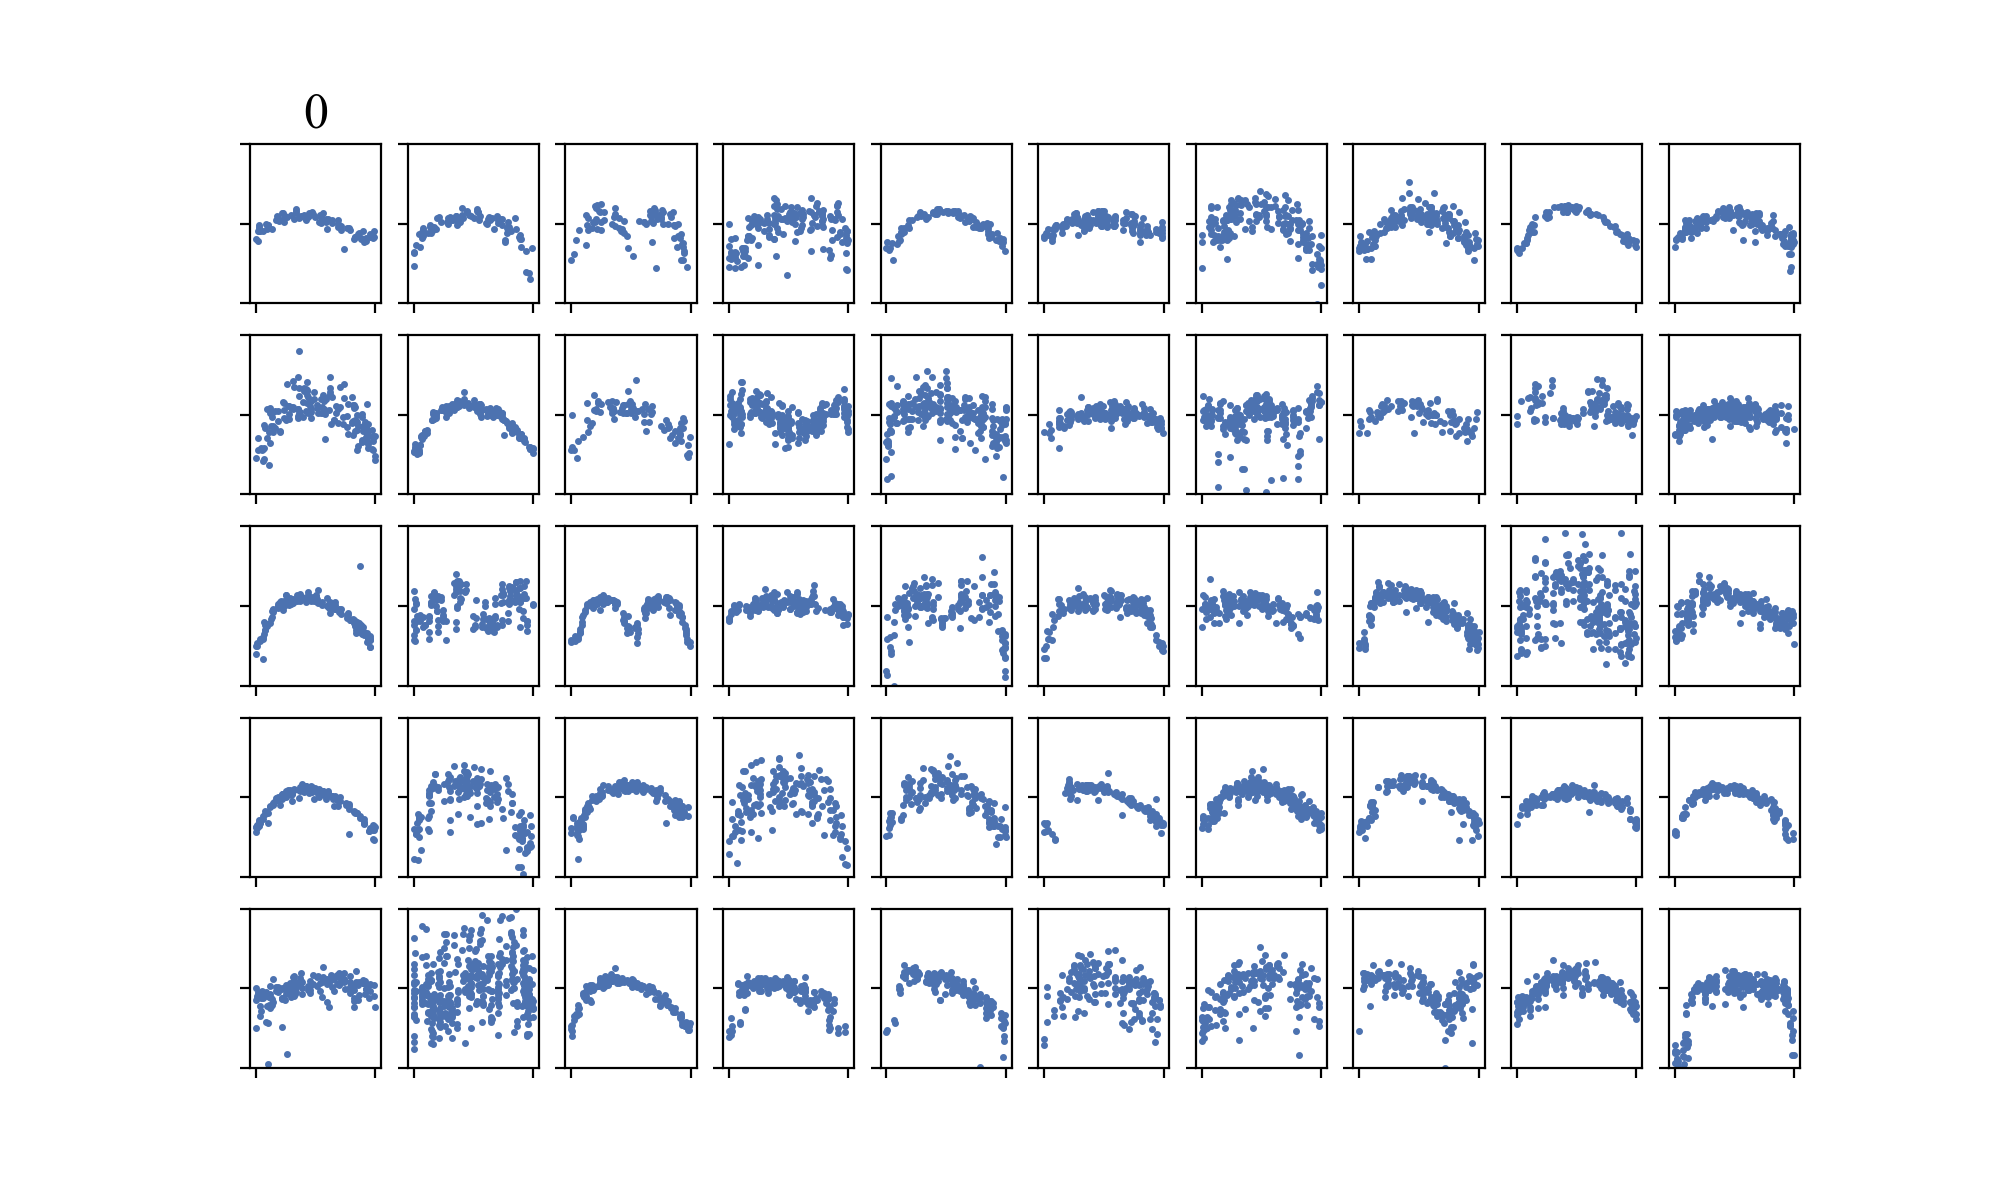

In [122]:
NY,NX=5,10
f,a=plt.subplots(NY,NX,figsize=[10,6],sharex=True,sharey=True)
a = a.flatten()

def plllt(lc,period,ax):
    plt.sca(ax)
    plt.cla()
    clean = (lc['filterid']==5)&(lc['ambiguous_match']==0)&(lc['ast_res_chisq']<13.)
    min_t = lc['mjdobs'][clean].values[np.argsort(lc['mag'][clean].values)[-5]]
    plt.plot(((lc['mjdobs'][clean]-min_t)%(period)/period),lc['mag'][clean]-np.nanmedian(lc['mag'][clean]),'.',
            ms=3)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])

event_subplots={}
chunk_index=0

def plot_cl(ain):
    plt.sca(a[ain])
    plt.cla()
    
def plot_grid(chunk):
    
    s = dataset['sourceid'].values[chunk*NY*NX:(chunk+1)*NY*NX]
    p = dataset['lsq_period'].values[chunk*NY*NX:(chunk+1)*NY*NX]
    p = p[np.argsort(s)]
    s = s[np.argsort(s)]
    lcs = get_lightcurve_bulk(s)
    
    global event_subplots
    event_subplots = {ss:l for l,ss in zip(s,a[:len(s)])}
    
    [plllt(lc,pp,ax) for lc, pp, ax in zip(lcs, p, a)]
    if len(s)<len(a):
        [plot_cl(ain) for ain in range(len(s),len(a))]
        
    plt.ylim(-0.5,0.5)
    plt.sca(a[0])
    plt.title(chunk_index,fontsize=18)
    plt.gca().invert_yaxis()

import os
from functools import partial

cache=0
axis=None

def onclick(event):
    global cache
    global axis
    axis = event.inaxes
    cache = event_subplots[axis]
    
def on_press(event):
    sys.stdout.flush()
    global chunk_index
    if event.key == 'd':
        chunk_index+=1
        plot_grid(chunk_index)
    if event.key == 'a':
        chunk_index-=1
        plot_grid(chunk_index)
    elif event.key == 'w':
        with open(output_file, 'a') as w:
            w.write('%i,%s\n' % (cache,'contam'))
        axis.set_facecolor('xkcd:light salmon')
    elif event.key == 'e':
        with open(output_file, 'a') as w:
            w.write('%i,%s\n' % (cache,'likely contam'))
        axis.set_facecolor('xkcd:light rose')
    elif event.key == 'r':
        with open(output_file, 'a') as w:
            w.write('%i,%s\n' % (cache,'per double'))
        axis.set_facecolor('xkcd:light blue')
    elif event.key == 'z':
        tmp='tmp'
        with open('tmp', 'w') as t:
            subprocess.call(['head','-n','-1',output_file],stdout=t)
        subprocess.call(['mv',tmp,output_file])
        axis.set_facecolor('white')

plot_grid(0)
pid= f.canvas.mpl_connect('key_press_event', on_press)
cid = f.canvas.mpl_connect('button_press_event', onclick)

plt.show()